In [1]:
from qiskit import *
from qiskit.tools.monitor import job_monitor

import numpy as np
import pylab as pl

import networkx as nx
from qiskit.visualization import *
from scipy import optimize as opt
from qaoa import *
import os
from matplotlib import rc
font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

import sys
sys.path.append('../')

from qiskit_utilities.utilities import *
from qiskit_utilities.download import *

### Let us import and draw the graph

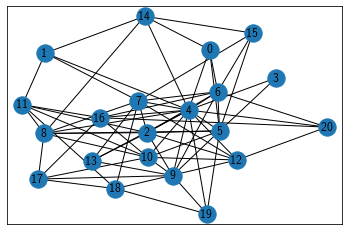

In [2]:
k_cuts=2
numV=21
G = nx.read_gml("../data/sample_graphs/w_ba_n"+str(numV)+"_k4_0.gml")
pos = nx.spring_layout(G)
nx.draw_networkx(G,pos=pos)

### Draw the histogram of number of solutions for value of cost function

In [3]:
file_name = "w_ba_n"+str(numV)+"_k4_0_costs.npy"
if not os.path.isfile(file_name):
    ## we could run the next line, but it takes several hours
    #costs=costsHist_MaxCut(G)
    ## therefore, we just download
    url = "https://zenodo.org/record/3730499/files/"+file_name
    downloadfile(url,file_name)
costs=np.load(file_name)

In [4]:
max_val=max(costs)
print("cost of optimal solution(s) = ", max_val)

cost of optimal solution(s) =  25.23404480588015


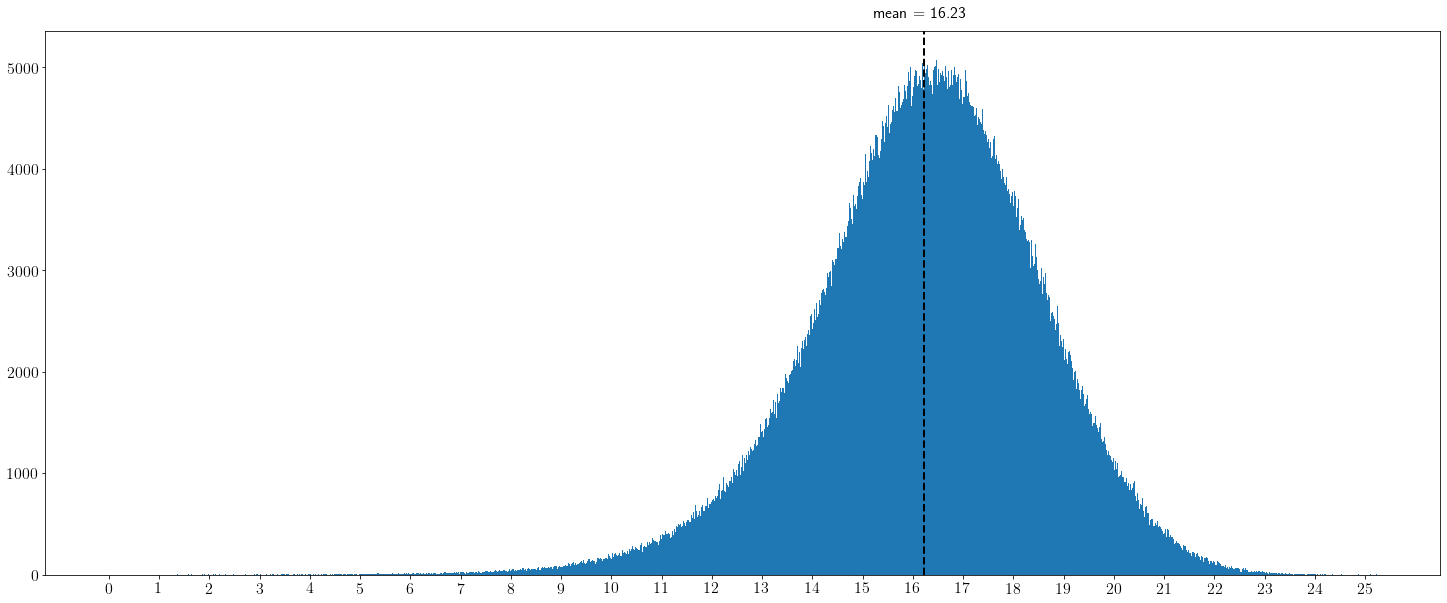

In [5]:
pl.figure(figsize=(25,10))
a=pl.hist(np.sort(costs), bins=2000)
min_ylim, max_ylim = pl.ylim()
max_ylim *=1.025
mean=np.mean(costs)
pl.axvline(mean, color='k', linestyle='dashed', linewidth=2)
a=pl.text(mean-1, max_ylim, 'mean = {:.2f}'.format(mean))
a=pl.xticks(np.arange(0, max_val, step=1))

### Only 3.94% of all solutions have a cost of 20 or higher

In [6]:
num_good_solutions=0
for i in range(0,costs.shape[0]):
    if costs[i]>=20:
        num_good_solutions+=1
print("There are", num_good_solutions, "solutions with cost 20 or higher, which is", num_good_solutions/2**numV*100, "% of all solutions.")

There are 82532 solutions with cost 20 or higher, which is 3.9354324340820312 % of all solutions.


### There is only 1 optimal solution (modulo symmetry)

In [7]:
num_optimal_solutions=0
for i in range(0,costs.shape[0]):
    if costs[i]>=max_val:
        num_optimal_solutions+=1
print("There are", num_optimal_solutions, "solutions with maximum cost =",
      max_val ,", which is", num_optimal_solutions/2**numV*100, "% of all solutions.")

There are 2 solutions with maximum cost = 25.23404480588015 , which is 9.5367431640625e-05 % of all solutions.


### Calculate the energy landscape (this takes time)

In [8]:
Aer.backends()
backend_sim = Aer.get_backend('qasm_simulator')

In [9]:
version=1
circuits=[]
n=12
m=48
beta_max=np.pi
gamma_max=4*np.pi
job_string="w_ba_n"+str(numV)+"_k4_0_"+str(n)+"x"+str(m)

if os.path.isfile("../data/sample_graphs/"+job_string+"_Elandscape_v1.npy"):
    Elandscape_v1 = np.load("../data/sample_graphs/"+job_string+"_Elandscape_v1.npy")
else:
    for beta in np.linspace(0,beta_max,n):
        for gamma in np.linspace(0,gamma_max,m):
            circuits.append(createCircuit_MaxCut(np.array((gamma,beta)),G,1,k_cuts,version))
    job_sim = execute(circuits, backend_sim, shots=1024*2*2*2)
    Elandscape_v1,_,_ = measurementStatistics_MaxCut(job_sim.result().results, options={'G' : G, 'k_cuts' : k_cuts})
    Elandscape_v1 = -Elandscape_v1
    np.save("../data/sample_graphs/"+job_string+"_Elandscape_v1", Elandscape_v1)

### Define function for the optimizer

In [10]:
def getval(x, backend, depth=1, version=1, noisemodel=None):
    j = execute(createCircuit_MaxCut(x,G,depth,k_cuts,version), backend, noise_model=noisemodel, shots=1024*2*2*2)
    val,_,_=measurementStatistics_MaxCut(j.result().results, options={'G' : G, 'k_cuts' : k_cuts})
    global it, values, gamma, beta
    print(x)
    it+=1
    gamma[str(it)] = x[0]
    beta[str(it)] = x[1]
    values[str(it)] = val
    return -val[0]

### Run the optimizatoin using Nelder-Mead (derivative free method)

[0.5 1.3]
[0.525 1.3  ]
[0.5   1.365]
[0.475 1.365]
[0.45   1.3975]
[0.45   1.4625]
[0.425   1.54375]
[0.375   1.57625]
[0.3125   1.681875]
[0.2875   1.828125]
[0.20625   2.0434375]
[0.175   1.96625]
[0.15   2.1125]
[0.271875   1.78953125]
[0.384375   1.65140625]
[0.22734375 1.88753906]
[0.33203125 1.73011719]
[0.25351562 1.84818359]
[0.30585937 1.76947266]
[0.26660156 1.82850586]
[0.29277344 1.78915039]
[0.30839844 1.82774414]
[0.32666016 1.84685059]
[0.303125   1.86671875]
[0.32402344 1.86633789]
[0.32929687 1.82736328]
[0.30966797 1.85687988]
[0.31621094 1.84704102]
[0.30576172 1.84723145]
[0.31884766 1.82755371]
[0.3090332  1.84231201]
[0.31557617 1.83247314]
[0.31394043 1.83493286]
[0.31230469 1.83739258]
[0.31262207 1.84467651]
Optimization terminated successfully.
         Current function value: -17.030687
         Iterations: 17
         Function evaluations: 35
Optimal value= [0.31621094 1.84704102]


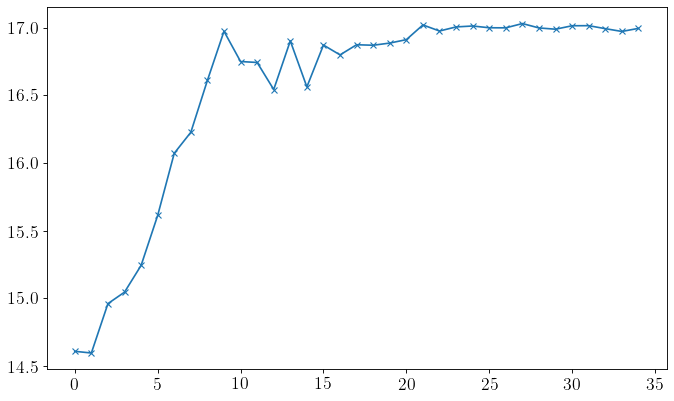

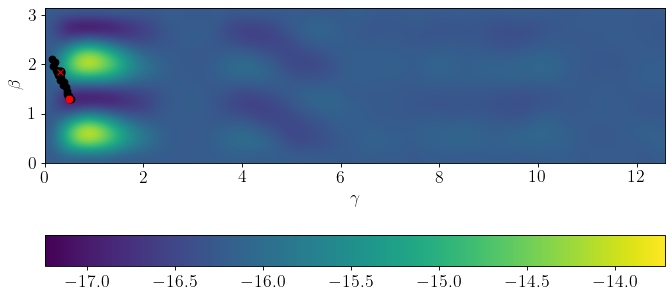

In [11]:
version=1
it=0
gamma={}
beta={}
values={}
xin=(.5,1.3)
out=opt.minimize(getval, x0=xin, method='Nelder-Mead',\
                 args=(backend_sim,1,version,None),\
             options={'xatol': 1e-2, 'fatol': 1e-1, 'disp': True})
print("Optimal value=",out.x)
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(list(values.values()),'x-')

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.imshow(np.array(Elandscape_v1).reshape(n,m),interpolation='bicubic',origin='lower',extent=[0,gamma_max,0,beta_max])
pl.colorbar(orientation="horizontal", pad=0.2)
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.plot(list(gamma.values()),list(beta.values()),'ko-')
pl.plot(xin[0],xin[1],'or')
pl.plot(out.x[0],out.x[1],'xr')

### Pick the best solution and its parameters along the optimization path

In [12]:
tmp = max(values, key=values.get)
x_best=(gamma[tmp], beta[tmp])
print(values[tmp], x_best)

[17.030686515430567] (0.3162109374999995, 1.8470410156250017)


### Calculate the average and maximum cost for the optimal parameters found with varying number of shots

In [13]:
num_shots=[]
bins_states={}
max_cost=[]
average_cost=[]
max_sol={}
for i in range(4,14):
    ns=2**i
    num_shots.append(ns)
    jv1 = execute(createCircuit_MaxCut(x_best,G,1,k_cuts,version), backend_sim, shots=ns)
    bins_states[ns], mc, ac, max_sol[ns] = bins_comp_basis(jv1.result().get_counts(),G, k_cuts)
    max_cost.append(mc)
    average_cost.append(ac)

### Calculate the average and maximum cost for random solutions with varying number of shots

In [14]:
import random
bins_states_rand={}
max_cost_rand=[]
average_cost_rand=[]
max_sol_rand={}
for i in range(4,14):
    ns=2**i
    tmp_states={}
    for j in range(0,ns):
        s = random.randint(0, ns - 1)
        binstring="{0:b}".format(s).zfill(numV)
        y=[int(i) for i in binstring]
        c=cost_MaxCut(y,G, k_cuts)
        tmp_states[binstring]=c
    bins_states_rand[ns], mc, ac, max_sol_rand[ns] = bins_comp_basis(tmp_states,G, k_cuts)
    max_cost_rand.append(mc)
    average_cost_rand.append(ac)

### Plot comparison of random solution and QAOA

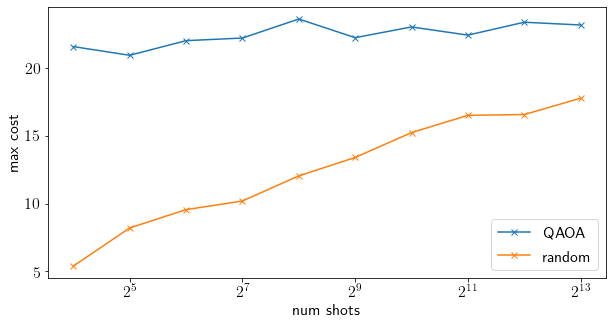

In [15]:
pl.figure(figsize=(10,5))
pl.semilogx(num_shots, max_cost,'x-', base=2, label='QAOA')
pl.semilogx(num_shots, max_cost_rand,'x-', base=2, label='random')
pl.legend()
pl.ylabel('max cost')
tmp=pl.xlabel('num shots')

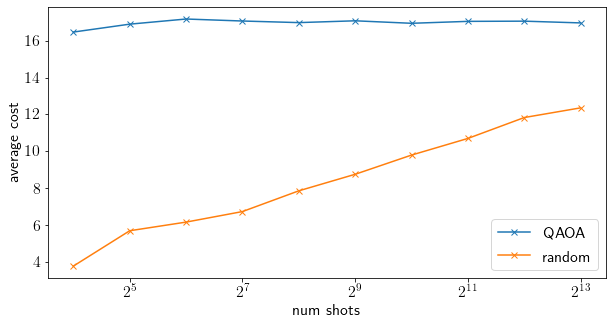

In [16]:
pl.figure(figsize=(10,5))
pl.semilogx(num_shots, average_cost,'x-', base=2, label='QAOA')
pl.semilogx(num_shots, average_cost_rand,'x-', base=2, label='random')
pl.legend()
pl.ylabel('average cost')
tmp=pl.xlabel('num shots')